# Google Landmark Detection
This project trains a deep learning model to classify landmarks using the Google Landmark Dataset v2.


In [24]:
#consist of visual analysis based on neural networks ....
#this is the project of google landmark detection...
#Used 'google landmark detection dataset v2'
#CNN is very suited for image analysis

 ### Steps invovled
 - data collection from 'https://github.com/cvdfoundation/google-landmark'
 - preprocessing
     - resizing images
     - normalization of pixels
     - augmentations
     - rotating
     - flipping
     - scaling
     - encoding
 - model creation
     - Sequential layer
     - input layer
     - hidden layer
         - CNN
         - Max Polling
         - Full connected layers
 - split the data
 - train data
 - test the model -metric,accuracy,f1 score
     - model used is vgg19

## Step 1: Import Required Libraries
Import TensorFlow, Keras, NumPy, Pandas, and other utilities.


In [3]:
# =========================
# Landmark Detection - Custom Dataset
# =========================

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Step 2: Dataset Preparation
- Define dataset path  
- Load image file paths and labels into a dataframe  
- Split into training and validation sets

In [4]:
# =========================
# Step 1: Paths & DataFrame
# =========================
base_path = r"C:\Users\pc\Desktop\Projects\ColandProject_Improvised\images_000"

filepaths = []
labels = []

for label in os.listdir(base_path):
    folder = os.path.join(base_path, label)
    if os.path.isdir(folder):
        for fname in os.listdir(folder):
            if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                filepaths.append(os.path.join(label, fname))
                labels.append(label)

df = pd.DataFrame({"filepath": filepaths, "label": labels})

# Encode labels
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["label"])

print("Total samples:", len(df))
print(df.head())

Total samples: 16157
                 filepath  label
0  0\0000059611c7d079.jpg      0
1  0\0000070506c174cc.jpg      0
2  0\000008ae30de967e.jpg      0
3  0\000014b1f770f640.jpg      0
4  0\000015f76534add3.jpg      0


## Step 3: Data Preprocessing
Create custom data generator to load, resize, and normalize images batch-wise.


In [5]:
# =========================
# Step 2: Train/Val split
# =========================
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

print("Train samples:", len(train_df), " Val samples:", len(val_df))

# =========================
# Step 3: Dataset class
# =========================
class MyDataset(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, base_path, target_size=(224,224)):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.base_path = base_path
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]

        images, labels = [], []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.base_path, row["filepath"])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            img = img.astype(np.float32) / 255.0

            images.append(img)
            labels.append(row["label"])

        return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

Train samples: 12925  Val samples: 3232


## Step 4: Model Architecture
Define a CNN-based model using Keras Sequential API with Conv2D, MaxPooling, and Dense layers.

In [6]:
# =========================
# Step 4: Model
# =========================
num_classes = df["label"].nunique()

source_model = VGG19(weights=None, include_top=False, input_shape=(224,224,3))

model = Sequential()
for layer in source_model.layers:
    model.add(layer)

model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 122,854,480 (468.65 MB)

 Trainable params: 122,854,480 (468.65 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Model Training
Train the model using the training generator and validate on the validation set.


In [7]:
# =========================
# Step 5: Training
# =========================
batch_size = 16
epochs = 5

train_seq = MyDataset(train_df, batch_size, base_path)
val_seq   = MyDataset(val_df, batch_size, base_path)

# sanity check
X_batch, y_batch = train_seq[0]
print("Batch shape:", X_batch.shape, "Labels shape:", y_batch.shape)

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)


Batch shape: (16, 224, 224, 3) Labels shape: (16,)
Epoch 1/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0577 - loss: 2.7729     

808/808 ━━━━━━━━━━━━━━━━━━━━ 5290s 7s/step - accuracy: 0.0573 - loss: 2.7729 - val_accuracy: 0.0650 - val_loss: 2.7723
Epoch 2/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0613 - loss: 2.7728     

808/808 ━━━━━━━━━━━━━━━━━━━━ 5047s 6s/step - accuracy: 0.0610 - loss: 2.7728 - val_accuracy: 0.0650 - val_loss: 2.7723
Epoch 3/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0647 - loss: 2.7726     

808/808 ━━━━━━━━━━━━━━━━━━━━ 5085s 6s/step - accuracy: 0.0631 - loss: 2.7726 - val_accuracy: 0.0650 - val_loss: 2.7722
Epoch 4/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0630 - loss: 2.7726     

808/808 ━━━━━━━━━━━━━━━━━━━━ 5086s 6s/step - accuracy: 0.0638 - loss: 2.7726 - val_accuracy: 0.0644 - val_loss: 2.7722
Epoch 5/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0613 - loss: 2.7727     

808/808 ━━━━━━━━━━━━━━━━━━━━ 5119s 6s/step - accuracy: 0.0594 - loss: 2.7726 - val_accuracy: 0.0650 - val_loss: 2.7722


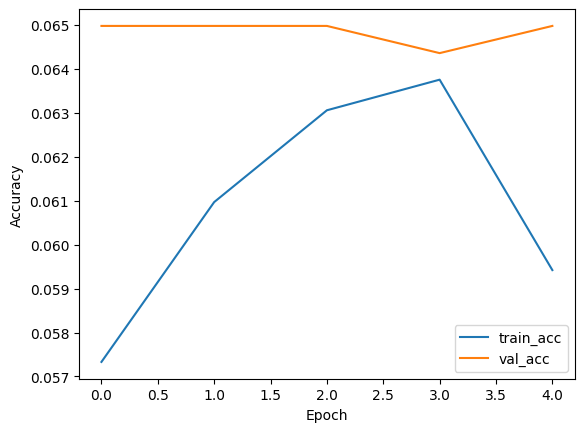

In [8]:
# =========================
# Step 6: Plot history
# =========================
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [9]:
# =========================
# Step 7: Save final model
# =========================
model.save("final_model.h5")
print("✅ Training complete and model saved.")

✅ Training complete and model saved.


## Step 6: Model Evaluation
Evaluate predictions on validation data.  
Track good and bad predictions for analysis.


In [15]:
# =========================
# Helper: Batch generator
# =========================
def get_batch(df, start, batch_size, base_path):
    """Fetch a batch of images and labels from dataframe."""
    batch_paths = df.iloc[start:start+batch_size]['filepath'].values
    batch_labels = df.iloc[start:start+batch_size]['label'].values

    images = []
    for img_rel_path in batch_paths:
        img_path = os.path.join(base_path, img_rel_path)  
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))  # resize to match model input
        img = img.astype("float32") / 255.0
        images.append(img)

    X = np.array(images)
    y = np.array(batch_labels)
    return X, y

In [16]:
# =========================
# Step 1: Evaluate predictions
# =========================
batch_size = 16
errors = 0
good_preds = []
bad_preds = []

for it in range(int(np.ceil(len(val_df) / batch_size))):
    X_val, y_val = get_batch(val_df, it * batch_size, batch_size, base_path)

    result = model.predict(X_val)
    cla = np.argmax(result, axis=1)

    for idx, res in enumerate(result):
        if cla[idx] != y_val[idx]:
            errors += 1
            bad_preds.append([batch_size * it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size * it + idx, cla[idx], res[cla[idx]]])

print(f"Total errors: {errors}")
print(f"Good predictions: {len(good_preds)}")
print(f"Bad predictions: {len(bad_preds)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━

In [17]:
# =========================
# Step 2: Visualization helper
# =========================
def get_image_from_number(n, df):
    """Fetch image and label by index from dataframe."""
    row = df.iloc[n]
    img_path = os.path.join(base_path, row['filepath'])  
    img = cv2.imread(img_path)
    lbl = row['label']
    return img, lbl

def decode_label(lbl_array):
    """Inverse transform integer label back to original class."""
    return le.inverse_transform(lbl_array.flatten())

In [21]:
from sklearn.preprocessing import LabelEncoder

# Recreate label encoder and fit with all labels
le = LabelEncoder()
le.fit(df['label'])

LabelEncoder()

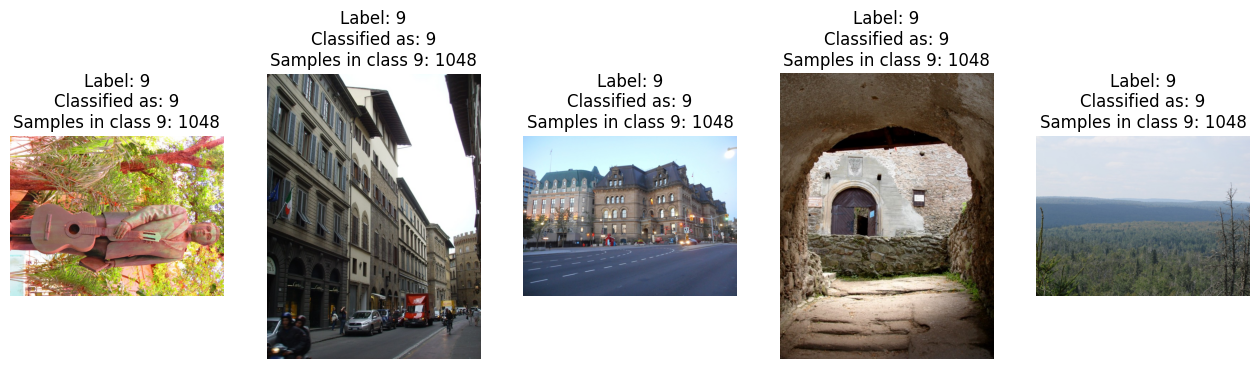

In [22]:
# =========================
# Step 3: Show sample predictions
# =========================
fig = plt.figure(figsize=(16, 16))
for i in range(1, 6):  
    n = int(good_preds[i][0])
    img, lbl = get_image_from_number(n, val_df)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig.add_subplot(1, 5, i)
    plt.imshow(img)

    lbl2 = np.array(int(good_preds[i][1])).reshape(1, 1)
    sample_cnt = list(df.label).count(lbl)

    plt.title(
        f"Label: {lbl}\n"
        f"Classified as: {decode_label(lbl2)[0]}\n"
        f"Samples in class {lbl}: {sample_cnt}"
    )
    plt.axis("off")

plt.show()

In [10]:
import os
print(os.getcwd())
print(os.listdir())


C:\Users\pc
['.anaconda', '.android', '.astropy', '.bash_history', '.cache', '.conda', '.condarc', '.config', '.continuum', '.eclipse', '.emulator_console_auth_token', '.git', '.gitconfig', '.gradle', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.lesshst', '.m2', '.matplotlib', '.ms-ad', '.nbi', '.node_repl_history', '.p2', '.packettracer', '.spyder-py3', '.streamlit', '.vscode', 'Adarsh_Proj', 'anaconda3', 'AndroidStudioProjects', 'ansel', 'AppData', 'Application Data', 'best_model.h5', 'Cisco Packet Tracer 7.3.0', 'Cisco Packet Tracer 8.2.2', 'Contacts', 'Cookies', 'Desktop', 'Documents', 'Downloads', 'Favorites', 'final_model.h5', 'git', 'Google_Landmark_Detection.ipynb', 'Home', 'Links', 'Local Settings', 'Music', 'My Documents', 'MyFirstDir', 'MyProjectDIR', 'NetHood', 'newProjectDir', 'node_modules', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{c18dc5f8-b2e7-11ef-a96b-d071dbc57cdf}.TM.blf', 'NTUSER.DAT{c18dc5f8-b2e7-11ef-a96b-d071dbc57cdf

## Step 8: Save Trained Model
Save the trained model in `.keras` format for future use.

In [11]:
save_dir = r"C:\Users\pc\Desktop\Projects\ColandProject_Improvised\models"
os.makedirs(save_dir, exist_ok=True)

model.save(os.path.join(save_dir, "final_model.keras")) 
print("✅ Training complete and model saved at:", save_dir)


✅ Training complete and model saved at: C:\Users\pc\Desktop\Projects\ColandProject_Improvised\models


In [14]:
print(val_df.columns)


Index(['filepath', 'label'], dtype='object')


In [ ]:
# model.save("final_model.h5")   
# model.save_weights("final_model_weights.h5")